# Convexity Correction

# 👉 <a id = "top">Table of Contents</a> 👈 

# [1. Functions](#p1)

# [2. CMS 10y semi-annually over the next 5 years](#p2)

# [3. CMS 2y quarterly over the next 10 years](#p3)

# [4. Comparing forward swap rates with the CMS rate](#p4)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.stats import norm
from scipy.interpolate import interp1d

# <a id = "p1">1.</a>  <font color = "green"> Functions </font>  [back to table of contents](#top)

In [2]:
def g_0(K):
    return K

def g_1(K):
    return 1.0

def g_2(K):
    return 0.0

### IRR Functions and Their Derivatives

The following functions represent the **Internal Rate of Return (IRR)** and its first and second derivatives with respect to the strike \( K \). These are useful in interest rate derivatives pricing, especially for convexity adjustments or sensitivity analysis.

#### 1. Zero-th Order IRR Function
This is the standard IRR expression:

$$
\text{IRR}_0(K) = \frac{1}{K} \left( 1 - \frac{1}{(1 + \frac{K}{m})^{\text{tenor} \cdot m}} \right)
$$

#### 2. First Derivative of IRR
This represents the sensitivity of the IRR with respect to \( K \):

$$
\text{IRR}_1(K) = -\frac{1}{K} \cdot \text{IRR}_0(K) + \frac{1}{K \cdot m} \cdot \text{tenor} \cdot m \cdot \frac{1}{(1 + \frac{K}{m})^{\text{tenor} \cdot m + 1}}
$$

#### 3. Second Derivative of IRR
This captures the convexity of IRR with respect to \( K \):

$$
\text{IRR}_2(K) = -\frac{2}{K} \cdot \text{IRR}_1(K) - \frac{1}{K \cdot m^2} \cdot (\text{tenor} \cdot m)(\text{tenor} \cdot m + 1) \cdot \frac{1}{(1 + \frac{K}{m})^{\text{tenor} \cdot m + 2}}
$$

These expressions are parameterized by:
- \( K \): Strike rate
- \( m \): Compounding frequency (e.g., 2 for semiannual)
- \( $\text{tenor}$ \): Length of the swap in years

In [3]:
def IRR_0(K, m, tenor):
    # Implementation of IRR(K) function
    value = 1/K * ( 1.0 - 1/(1 + K/m)**(tenor*m) )
    return value

def IRR_1(K, m, tenor):
    # Implementation of IRR'(K) function (1st derivative)
    firstDerivative = -1/K*IRR_0(K, m, tenor) + 1/(K*m)*tenor*m/(1+K/m)**(tenor*m+1)
    return firstDerivative

def IRR_2(K, m, tenor):
    # Implementation of IRR''(K) function (2nd derivative)
    secondDerivative = -2/K*IRR_1(K, m, tenor) - 1/(K*m*m)*(tenor*m)*(tenor*m+1)/(1+K/m)**(tenor*m+2)
    return secondDerivative

### \( h(K) \) and Its Derivatives

The function \( h(K) \) is defined as the ratio of another function \( $g_0(K)$ \) to the IRR function:

#### Base Function:
$$
h_0(K) = \frac{g_0(K)}{\text{IRR}_0(K)}
$$

#### First Derivative:
Using the quotient rule:
$$
h_1(K) = \frac{\text{IRR}_0(K) \cdot g_1(K) - g_0(K) \cdot \text{IRR}_1(K)}{\left( \text{IRR}_0(K) \right)^2}
$$

#### Second Derivative:
Applying the quotient rule again:
\[
\begin{aligned}
h_2(K) &= \frac{
    \text{IRR}_0(K) \cdot g_2(K)
    - \text{IRR}_2(K) \cdot g_0(K)
    - 2 \cdot \text{IRR}_1(K) \cdot g_1(K)
}{
    \left( \text{IRR}_0(K) \right)^2
}
+ \frac{
    2 \cdot \text{IRR}_1(K) \cdot g_0(K)
}{
    \left( \text{IRR}_0(K) \right)^3
}
\end{aligned}
\]

These expressions are used to analyze the sensitivity and convexity of pricing functions involving the IRR.


In [4]:
def h_0(K, m, tenor):
    # implementation of h(K)
    value = g_0(K) / IRR_0(K, m, tenor)
    return value

def h_1(K, m, tenor):
    # implementation of h'(K) (1st derivative)
    firstDerivative = (IRR_0(K, m, tenor)*g_1(K) - g_0(K)*IRR_1(K, m, tenor)) / IRR_0(K, m, tenor)**2
    return firstDerivative

def h_2(K, m, tenor):
    # implementation of h''(K) (2nd derivative)
    secondDerivative = ((IRR_0(K, m, tenor)*g_2(K) - IRR_2(K, m, tenor)*g_0(K) - 2.0*IRR_1(K, m, tenor)*g_1(K))/IRR_0(K, m, tenor)**2 
                        + 2.0*IRR_1(K, m, tenor)**2*g_0(K)/IRR_0(K, m, tenor)**3)
    return secondDerivative

In [5]:
## Import IRS Data
Discount_Factors = pd.read_csv("Discount_Factors.csv")
Discount_Factors

,Years,Rate,OIS_Discount_Factor,IRS_Discount_Factor,Forward_LIBOR
0,0.5,0.025000,0.998752,0.987654,0.025000
1,1.0,0.028000,0.997009,0.972496,0.031245
2,1.5,0.029000,0.995268,0.957338,0.031242
3,2.0,0.030000,0.993531,0.942179,0.033275
4,2.5,0.030750,0.991771,0.926330,0.034038
5,3.0,0.031500,0.990015,0.910482,0.035565
6,3.5,0.032000,0.988064,0.894731,0.035309
7,4.0,0.032500,0.986117,0.878981,0.036328
8,4.5,0.032750,0.984148,0.863985,0.035053
9,5.0,0.033000,0.982184,0.848989,0.035562


In [6]:
# Get df for quarterly payments using zero rates
new_expiry = np.arange(0.25, Discount_Factors["Years"].max() + 0.25, 0.25)

# Reindex to include desired quarterly points
Discount_Factors = Discount_Factors.set_index("Years").reindex(new_expiry)

# Interpolate linearly
Discount_Factors = Discount_Factors.interpolate(method="linear")

# Fill any edge NaNs if they exist (e.g. at start/end)
Discount_Factors = Discount_Factors.bfill().ffill()

# Reset index and rename
Discount_Factors.reset_index(inplace=True)
Discount_Factors.rename(columns={"index": "Years"}, inplace=True)

Discount_Factors

,Years,Rate,OIS_Discount_Factor,IRS_Discount_Factor,Forward_LIBOR
0,0.25,0.025000,0.998752,0.987654,0.025000
1,0.50,0.025000,0.998752,0.987654,0.025000
2,0.75,0.026500,0.997880,0.980075,0.028122
3,1.00,0.028000,0.997009,0.972496,0.031245
4,1.25,0.028500,0.996139,0.964917,0.031243
...,...,...,...,...,...
115,29.00,0.049500,0.852548,0.242112,0.064818
116,29.25,0.049625,0.851265,0.237498,0.065077
117,29.50,0.049750,0.849983,0.232884,0.065336
118,29.75,0.049875,0.848704,0.228271,0.065595


In [7]:
## Import the SABR parameters in Part 2
Calibration_parameters_df = pd.read_csv('Calibration_parameters_df.csv')
Calibration_parameters_df

,start,tenor,Beta,alpha,rho,nu,sigma
0,1,1,2.083560e-12,0.139080,-0.632309,2.041878,0.2250
1,1,2,6.540861e-08,0.184666,-0.524760,1.674725,0.2872
2,1,3,7.485776e-13,0.196861,-0.482647,1.436639,0.2978
3,1,5,3.162905e-06,0.178061,-0.414392,1.064192,0.2607
4,1,10,2.493245e-05,0.169983,-0.255645,0.791994,0.2447
5,5,1,8.973592e-07,0.166618,-0.585668,1.340428,0.2726
6,5,2,1.570700e-07,0.199534,-0.547030,1.062006,0.2983
7,5,3,1.578997e-05,0.210314,-0.549687,0.936774,0.2998
8,5,5,7.319392e-06,0.190244,-0.506814,0.674547,0.2660
9,5,10,5.778883e-02,0.174809,-0.415705,0.511313,0.2451


In [8]:
Alpha = Calibration_parameters_df[["start","tenor","alpha"]]
Alpha = Alpha.pivot(index="start",columns="tenor",values="alpha")
Alpha

tenor,1,2,3,5,10
start,,,,,
1,0.139080,0.184666,0.196861,0.178061,0.169983
5,0.166618,0.199534,0.210314,0.190244,0.174809
10,0.178282,0.196313,0.208253,0.201583,0.180230


In [9]:
Rho = Calibration_parameters_df[["start","tenor","rho"]]
Rho = Rho.pivot(index="start",columns="tenor",values="rho")
Rho

tenor,1,2,3,5,10
start,,,,,
1,-0.632309,-0.524760,-0.482647,-0.414392,-0.255645
5,-0.585668,-0.547030,-0.549687,-0.506814,-0.415705
10,-0.548441,-0.547531,-0.553590,-0.563656,-0.508400


In [10]:
Nu = Calibration_parameters_df[["start","tenor","nu"]]
Nu = Nu.pivot(index="start",columns="tenor",values="nu")
Nu

tenor,1,2,3,5,10
start,,,,,
1,2.041878,1.674725,1.436639,1.064192,0.791994
5,1.340428,1.062006,0.936774,0.674547,0.511313
10,1.010309,0.928636,0.871689,0.722519,0.580364


In [11]:
forward_swap_rates = pd.read_csv("Forward_swap_rates_df.csv")   # From Part 1
forward_swap_rates = forward_swap_rates.merge(Calibration_parameters_df[["Beta","alpha","rho","nu","sigma"]],left_index=True,right_index=True,)
forward_swap_rates

,start,tenor,Forward_Swap_Rates,Beta,alpha,rho,nu,sigma
0,1,1,0.031922,2.083560e-12,0.139080,-0.632309,2.041878,0.2250
1,1,2,0.033217,6.540861e-08,0.184666,-0.524760,1.674725,0.2872
2,1,3,0.033982,7.485776e-13,0.196861,-0.482647,1.436639,0.2978
3,1,5,0.035238,3.162905e-06,0.178061,-0.414392,1.064192,0.2607
4,1,10,0.038419,2.493245e-05,0.169983,-0.255645,0.791994,0.2447
5,5,1,0.039274,8.973592e-07,0.166618,-0.585668,1.340428,0.2726
6,5,2,0.040075,1.570700e-07,0.199534,-0.547030,1.062006,0.2983
7,5,3,0.040072,1.578997e-05,0.210314,-0.549687,0.936774,0.2998
8,5,5,0.041093,7.319392e-06,0.190244,-0.506814,0.674547,0.2660
9,5,10,0.043634,5.778883e-02,0.174809,-0.415705,0.511313,0.2451


In [12]:
def black76_pay(F, K, expiry, tenor, sigma):
    """
    Return value of payer swaption via Black Normal model only
    parameters
        F: forward par swap rate given by forward IRS
        K: strike of swaption
        expiry: time to swaption expiry in years
        tenor: tenor of underlying swap in years
        sigma: annual vol
    """
    t = expiry
    d_1 = (np.log(F/K) + (1/2) * (sigma**2) * t) / (sigma * np.sqrt(t))
    d_2 = d_1 - sigma * np.sqrt(t)
    black_option = F * norm.cdf(d_1) - K * norm.cdf(d_2)
    return black_option

In [13]:
def black76_rec(F, K, expiry, tenor, sigma):
    """
    Return value of receiver swaption via Black Normal model Only
    parameters
        F: Forward par swap rate given by forward IRS
        K: strike of swaption
        expiry: time to swaption expiry in years
        tenor: tenor of underlying swap in years
        sigma: annual vol
    """
    t = expiry
    d_1 = (np.log(F/K) + (1/2) * (sigma**2) * t) / (sigma * np.sqrt(t))
    d_2 = d_1 - sigma * np.sqrt(t)
    black_option = K * norm.cdf(-d_2) - F * norm.cdf(-d_1)
    return black_option

In [14]:
def SABR(F, K, T, alpha, rho, nu, beta=0.9):
    """
    Use SABR model to return sigma, set beta to be 0.9
    """
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [15]:
# Carr-Madan Breeden-Litzenberger model free functions
def rec_integrand(F, K, expiry, tenor, alpha, rho, nu, m):
    """
    Return value of receiver integrand per CMS rate payoff. 
    formula: 2nd derivative h * V_rec(per SABR valuation) 
    parameters:
        m: payment freq per year, e.g. 2 is semi-annual
        F: par swap rate
        K: strike of CMS
        expiry: years to expiry of swaption
        tenor: tenor of underlying swap
        alpha: SABR param
        rho: SABR param
        nu: SABR param
    """
    sigma_sabr = SABR(F, K, expiry, alpha, rho, nu, beta=0.9)
    sabr_pricing = black76_rec(F, K, expiry, tenor, sigma_sabr)
    return h_2(K, m, tenor) * sabr_pricing

In [16]:
def pay_integrand(F, K, expiry, tenor, alpha, rho, nu, m):
    """
    Return value of receiver integrand per CMS rate payoff. 
    formula: 2nd derivative h * V_rec(per SABR valuation) 
    parameters:
        m: payment freq per year, e.g. 2 is semi-annual
        F: par swap rate
        K: strike of CMS
        expiry: years to expiry
        tenor: tenor of underlying swap
        alpha: SABR param
        rho: SABR param
        nu: SABR param
    """
    sigma_sabr = SABR(F, K, expiry, alpha, rho, nu, beta=0.9)
    sabr_pricing = black76_pay(F, K, expiry, tenor, sigma_sabr)
    return h_2(K, m, tenor) * sabr_pricing

In [17]:
def v_0(F, expiry, tenor, alpha, rho, nu, m):
    """
    Return forward CMS single coupon payoff based of static replication discounted to today's price. Uses SABR model
    parameters:
        F: par swap rate for given tenor
        expiry: swaption time to expiry
        tenor: underlying swap tenor
        alpha, rho, nu: SABR pricing model params
        m: underlying swap payment frequency per year
    """
    df_expiry = Discount_Factors.loc[Discount_Factors.Years == expiry]['OIS_Discount_Factor'].values[0]
    int_1 = IRR_0(F, m, tenor) * quad(lambda x: rec_integrand(F, x, expiry, tenor, alpha, rho, nu, m), 0.0, F)[0]
    int_2 = IRR_0(F, m, tenor) * quad(lambda x: pay_integrand(F, x, expiry, tenor, alpha, rho, nu, m), F, 0.1)[0]

    return df_expiry * F + int_1 + int_2

In [18]:
# function to compute pv of a series of cms payouts
def forward_cms_coupon(maturity, tenor, m):
    """
    Return PV of receiver leg for CMS as a series of periodic payments. 
    parameters:
        maturity: CMS maturity or swap tenor 
        tenor: tenor of CMS payments to be made
        m: frequency of payments per year
        par_swap_0: first swap rate at t=0 to be paid out in next payment date
    """
    # Data preparation
    df_fwd_irs = forward_swap_rates.loc[forward_swap_rates.tenor == maturity].copy()
    new_expiry = np.arange(0, tenor, 1/m)
    ls_v0 = []
    df_tmp = pd.DataFrame({"Expiry": new_expiry, 
                            "Tenor" : maturity})
    
    # Interpolate sabr params
    for col in ["alpha", "rho", "nu"]:
        interp_func = interp1d(df_fwd_irs["start"], 
                            df_fwd_irs[col], 
                            kind="linear", 
                            fill_value="extrapolate")
        df_tmp[col] = interp_func(new_expiry)
    # add par IRS  then interpolate par swap rates
    par_swap_0 = Discount_Factors.loc[Discount_Factors.Years==maturity,'Rate'].values[0]        # from part 1
    df_fwd_irs.loc[0] = {"start": 0, "Forward_Swap_Rates": par_swap_0} 
    df_fwd_irs.sort_values(by="start", inplace=True)
    interp_func = interp1d(df_fwd_irs["start"], 
                        df_fwd_irs['Forward_Swap_Rates'], 
                        kind="linear", 
                        fill_value="extrapolate")
    df_tmp['Forward_Swap_Rates'] = interp_func(new_expiry)

    # Iterate through fixing dates
    for expiry in new_expiry:
        if expiry == 0:
            coupon = df_tmp.iloc[0]['Forward_Swap_Rates']
            # print(f"{expiry}: {coupon}")
            ls_v0.append(coupon)       # first payment is fixed at par swap for first period
            continue

        F = df_tmp.loc[df_tmp.Expiry == expiry].Forward_Swap_Rates.values[0]
        alpha = df_tmp.loc[df_tmp.Expiry == expiry].alpha.values[0]
        rho = df_tmp.loc[df_tmp.Expiry == expiry].rho.values[0]
        nu = df_tmp.loc[df_tmp.Expiry == expiry].nu.values[0]

        coupon =  v_0(F, expiry, maturity, alpha, rho, nu, m)
        # print(f"{expiry}: {coupon}")
        ls_v0.append(coupon)

    return np.sum(np.array(ls_v0)) / m, ls_v0

# <a id = "p2">2.</a>  <font color = "green"> CMS 10y semi-annually over the next 5 years </font>  [back to table of contents](#top)

In [19]:
res, _ = forward_cms_coupon(10, 5, 2)
f"PV of a leg receiving CMS10y semi-annually over the next 5 years {res:.5f}"

'PV of a leg receiving CMS10y semi-annually over the next 5 years 0.20638'

# <a id = "p3">3.</a>  <font color = "green"> CMS 2y quarterly over the next 10 years </font>  [back to table of contents](#top)

In [20]:
res, _ = forward_cms_coupon(2, 10, 4)
f"PV of a leg receiving CMS2y semi-annually over the next 10 years {res:.5f}"

'PV of a leg receiving CMS2y semi-annually over the next 10 years 0.38813'

In [21]:
Discount_Factors

,Years,Rate,OIS_Discount_Factor,IRS_Discount_Factor,Forward_LIBOR
0,0.25,0.025000,0.998752,0.987654,0.025000
1,0.50,0.025000,0.998752,0.987654,0.025000
2,0.75,0.026500,0.997880,0.980075,0.028122
3,1.00,0.028000,0.997009,0.972496,0.031245
4,1.25,0.028500,0.996139,0.964917,0.031243
...,...,...,...,...,...
115,29.00,0.049500,0.852548,0.242112,0.064818
116,29.25,0.049625,0.851265,0.237498,0.065077
117,29.50,0.049750,0.849983,0.232884,0.065336
118,29.75,0.049875,0.848704,0.228271,0.065595


# <a id = "p4">4.</a>  <font color = "green"> Comparing forward swap rates with the CMS rate </font>  [back to table of contents](#top)

In [22]:
forward_swap_rates

,start,tenor,Forward_Swap_Rates,Beta,alpha,rho,nu,sigma
0,1,1,0.031922,2.083560e-12,0.139080,-0.632309,2.041878,0.2250
1,1,2,0.033217,6.540861e-08,0.184666,-0.524760,1.674725,0.2872
2,1,3,0.033982,7.485776e-13,0.196861,-0.482647,1.436639,0.2978
3,1,5,0.035238,3.162905e-06,0.178061,-0.414392,1.064192,0.2607
4,1,10,0.038419,2.493245e-05,0.169983,-0.255645,0.791994,0.2447
5,5,1,0.039274,8.973592e-07,0.166618,-0.585668,1.340428,0.2726
6,5,2,0.040075,1.570700e-07,0.199534,-0.547030,1.062006,0.2983
7,5,3,0.040072,1.578997e-05,0.210314,-0.549687,0.936774,0.2998
8,5,5,0.041093,7.319392e-06,0.190244,-0.506814,0.674547,0.2660
9,5,10,0.043634,5.778883e-02,0.174809,-0.415705,0.511313,0.2451


In [23]:
df_irs = forward_swap_rates.pivot(index='start',
                                columns='tenor', 
                                values='Forward_Swap_Rates')

ls_expiries = df_irs.index
ls_maturities = df_irs.columns

df_cms =  df_irs.copy()
dict_cms = {}

for maturity in ls_maturities:
    for expiry in ls_expiries:
        F = forward_swap_rates.loc[(forward_swap_rates.start==expiry) & (forward_swap_rates.tenor==maturity)]['Forward_Swap_Rates'].values[0]
        alpha = forward_swap_rates.loc[(forward_swap_rates.start==expiry) & (forward_swap_rates.tenor==maturity)]['alpha'].values[0]
        rho = forward_swap_rates.loc[(forward_swap_rates.start==expiry) & (forward_swap_rates.tenor==maturity)]['rho'].values[0]
        nu = forward_swap_rates.loc[(forward_swap_rates.start==expiry) & (forward_swap_rates.tenor==maturity)]['nu'].values[0]
        m = 2       # forward libor is in semi-annual payments, assume the same for CMS

        df_cms.at[expiry, maturity] = v_0(F, expiry, maturity, alpha, rho, nu, m)
        # print(expiry, maturity, v_0(F, expiry, maturity, alpha, rho, nu, m))

In [24]:
df_cms

tenor,1,2,3,5,10
start,,,,,
1,0.031936,0.033351,0.034188,0.035451,0.038864
5,0.039404,0.040658,0.041014,0.042335,0.046262
10,0.041731,0.043501,0.045288,0.048458,0.059305


In [25]:
df_cms.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 1 to 10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       3 non-null      float64
 1   2       3 non-null      float64
 2   3       3 non-null      float64
 3   5       3 non-null      float64
 4   10      3 non-null      float64
dtypes: float64(5)
memory usage: 252.0 bytes


In [26]:
df_irs

tenor,1,2,3,5,10
start,,,,,
1,0.031922,0.033217,0.033982,0.035238,0.038419
5,0.039274,0.040075,0.040072,0.041093,0.043634
10,0.042190,0.043116,0.044097,0.046249,0.053458


In [27]:
df_display = (df_cms / df_irs - 1) * 100
df_display.map(lambda x: f"{x:.1f}%")

tenor,1,2,3,5,10
start,,,,,
1,0.0%,0.4%,0.6%,0.6%,1.2%
5,0.3%,1.5%,2.4%,3.0%,6.0%
10,-1.1%,0.9%,2.7%,4.8%,10.9%


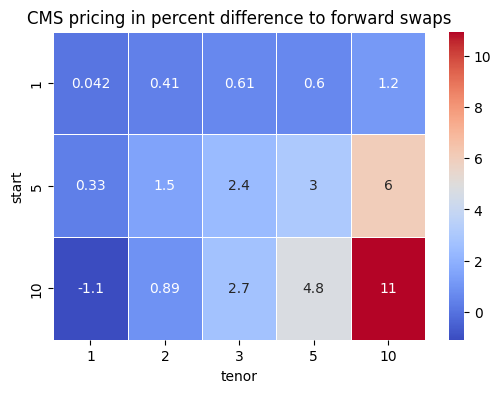

In [28]:
import seaborn as sns
# Create heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_display, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("CMS pricing in percent difference to forward swaps")
plt.show()

In [29]:
df_cms.reset_index(inplace=True)
df_cms = pd.melt(df_cms,id_vars="start").sort_values(by="start")

In [30]:
df_irs.reset_index(inplace=True)
df_irs = pd.melt(df_irs,id_vars="start").sort_values(by="start")

In [31]:
df_cms

,start,tenor,value
0,1,1,0.031936
3,1,2,0.033351
6,1,3,0.034188
9,1,5,0.035451
12,1,10,0.038864
1,5,1,0.039404
4,5,2,0.040658
7,5,3,0.041014
10,5,5,0.042335
13,5,10,0.046262


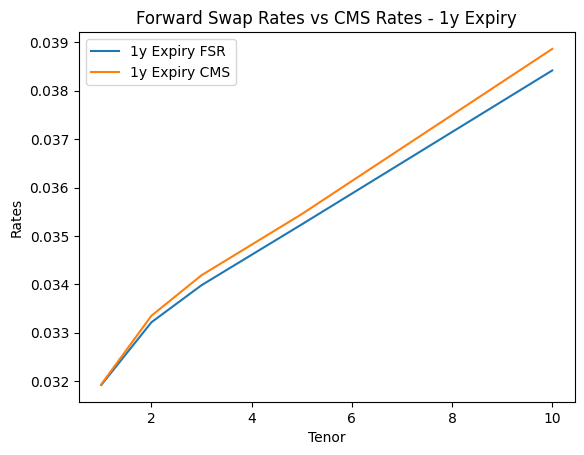

In [32]:
plt.plot(df_cms["tenor"][0:5],df_irs["value"][0:5],label='1y Expiry FSR')
plt.plot(df_cms["tenor"][0:5],df_cms["value"][0:5],label='1y Expiry CMS')
plt.xlabel('Tenor')
plt.ylabel('Rates')
plt.title('Forward Swap Rates vs CMS Rates - 1y Expiry')
plt.legend()
plt.show()

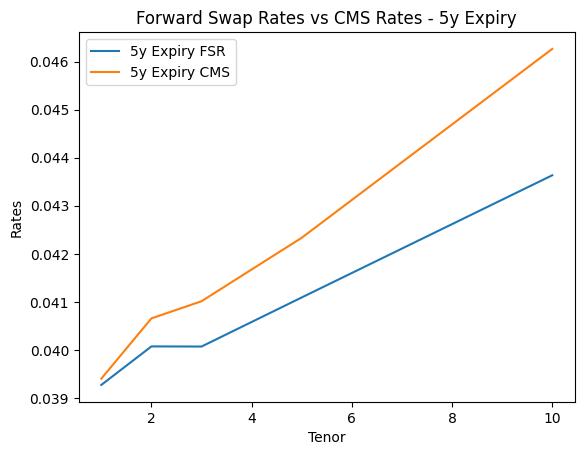

In [33]:
plt.plot(df_cms["tenor"][5:10],df_irs["value"][5:10],label='5y Expiry FSR')
plt.plot(df_cms["tenor"][5:10],df_cms["value"][5:10],label='5y Expiry CMS')
plt.xlabel('Tenor')
plt.ylabel('Rates')
plt.title('Forward Swap Rates vs CMS Rates - 5y Expiry')
plt.legend()
plt.show()

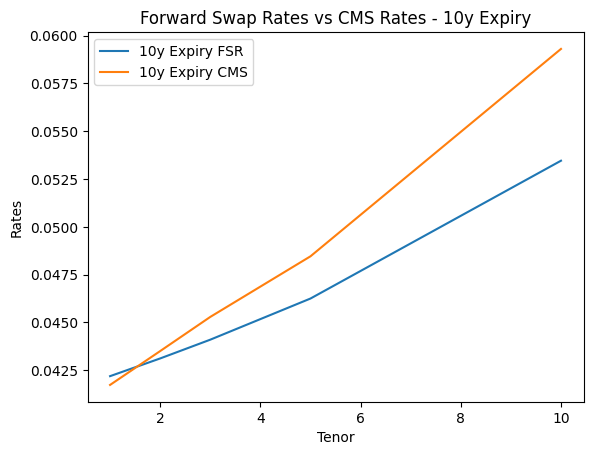

In [34]:
plt.plot(df_cms["tenor"][5:10],df_irs["value"][10:15],label='10y Expiry FSR')
plt.plot(df_cms["tenor"][5:10],df_cms["value"][10:15],label='10y Expiry CMS')
plt.xlabel('Tenor')
plt.ylabel('Rates')
plt.title('Forward Swap Rates vs CMS Rates - 10y Expiry')
plt.legend()
plt.show()